In [2]:
pip install pandas

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ----- ---------------------------------- 1.6/11.5 MB 9.4 MB/s eta 0:00:02
   ----------- ---------------------------- 3.4/11.5 MB 9.2 MB/s eta 0:00:01
   ------------------- -------------------- 5.5/11.5 MB 9.1 MB/s eta 0:00:01
   -------------------------- ------------- 7.6/11.5 MB 9.0 MB/s eta 0:00:01
   -------------------------------- ------- 9.4/11.5 MB 9.2 MB/s eta 0:00:01
   -------------------------------------- - 11.0/11.5 MB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 8.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install matplotlib

   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   --------- ------------------------------ 1.8/7.8 MB 9.1 MB/s eta 0:00:01
   ------------------ --------------------- 3.7/7.8 MB 9.1 MB/s eta 0:00:01
   ----------------------------- ---------- 5.8/7.8 MB 9.3 MB/s eta 0:00:01
   -------------------------------------- - 7.6/7.8 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 8.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------------------------- ------ 1.8/2.2 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 8.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------- ----------- 1.8/2.6 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 8.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install yfinance


     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ------------------------ --------------- 1.8/3.0 MB 9.1 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 8.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ------------------- -------------------- 1.8/3.8 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 3.8/3.8 MB 8.8 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-py3-none-any.whl size=138939 sha256=3a39dcc0160798c4ba119967b4df57b4510e02484df887bb80850b190c1031ac
  Stored in directory: c:\users\henry\appdata\local\pip\cache\wheels\

[*********************100%***********************]  1 of 1 completed
C:\Users\henry\AppData\Local\Temp\ipykernel_24180\3340117977.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['wf_top'] = df['wf_top'].ffill()
C:\Users\henry\AppData\Local\Temp\ipykernel_24180\3340117977.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['wf_bottom'] = df['wf_bottom'].ffill()


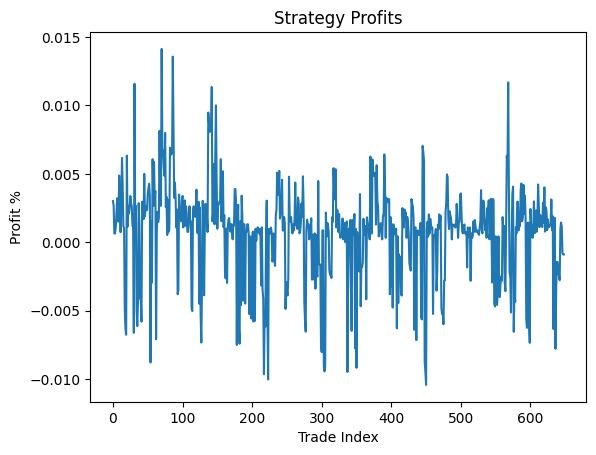

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

# Load data
df = yf.download('EURUSD=X', start='2023-09-05', interval='1h')
eur = df['Adj Close']

# Fractal Codes
# Buy condition
df['wf_top_bool'] = np.where(
    df['High'] == df['High'].rolling(9, center=True).max(), True, False)
df['wf_top'] = np.where(
    df['High'] == df['High'].rolling(9, center=True).max(), df['High'], None)
df['wf_top'] = df['wf_top'].ffill()

# Sell condition
df['wf_bottom_bool'] = np.where(
    df['Low'] == df['Low'].rolling(9, center=True).min(), True, False)
df['wf_bottom'] = np.where(
    df['Low'] == df['Low'].rolling(9, center=True).min(), df['Low'], None)
df['wf_bottom'] = df['wf_bottom'].ffill()

df.dropna(inplace=True)

# Order conditions
df['Buy'] = np.where((df.Close > df.wf_top), 1, 0)

# Set Stop Loss (SL) and Take Profit (TP)
df['SL'] = np.where(df.Buy == 1, df.wf_bottom.shift(1), 0)  # SL at previous down fractal
df['TP'] = np.where(df.Buy == 1, df.Close + (df.Close - df.Low) * 2, 0)

# Strategy logic
buys, sells = [], []

for i in range(len(df)):
    if df.Buy.iloc[i]:
        buy_time = df.index[i]  # Buy timestamp
        buy_price = df.Close.iloc[i]  # Buy price
        buys.append(buy_time)
        
        # Find sell point (either SL or TP)
        for j in range(1, len(df) - i):
            if df.Close.iloc[i + j] >= df.TP.iloc[i] or df.Close.iloc[i + j] <= df.SL.iloc[i]:
                sell_time = df.index[i + j]  # Sell timestamp
                sell_price = df.Close.iloc[i + j]  # Sell price
                sells.append(sell_time)
                break

# Create DataFrame for buys and sells
frame = pd.DataFrame({'buys': buys, 'sells': sells}).dropna()

# Filter out invalid trades (buy should be before sell)
actual_trades = frame[frame['buys'] < frame['sells']]

# Calculate profits in percentage terms
profits = (df.loc[actual_trades.sells].Close.values - df.loc[actual_trades.buys].Close.values) / df.loc[actual_trades.buys].Close.values

# Plot profits
plt.plot(profits)
plt.title("Strategy Profits")
plt.xlabel("Trade Index")
plt.ylabel("Profit %")
plt.show()


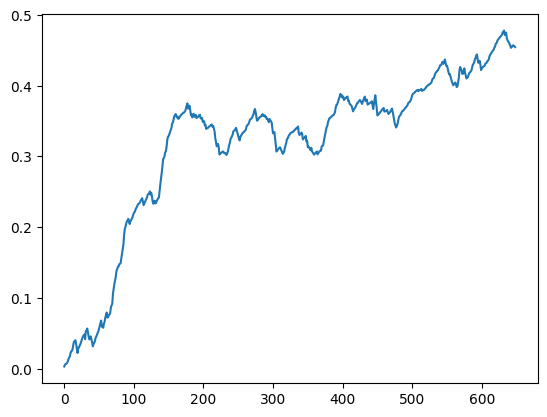

In [42]:
plt.plot(np.cumsum(profits))